# **Multiclass classification (BRCA/KIRC/COAD/LUAD/PRAD) using 20,531 gene-expression features (n=801)**

Models compared:

LassoNet (with/without CV, with dropout), L1 baseline, and a deep feedforward network.


Run cells top-to-bottom: load data → normalize/encode → train → evaluate (accuracy).

In [4]:
pip install lassonet

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from lassonet import LassoNetClassifier
import pandas as pd
from sklearn import preprocessing
from lassonet import LassoNetClassifier, plot_cv, plot_path
from lassonet.interfaces import LassoNetClassifierCV
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

In [6]:
# data preparation

!tar -xzf "TCGA-PANCAN-HiSeq-801x20531.tar.gz"
!ls -al
!ls -al "TCGA-PANCAN-HiSeq-801x20531"

base = "/content/TCGA-PANCAN-HiSeq-801x20531"

variables_df=pd.read_csv(f"{base}/data.csv", header=None, low_memory=False)
labels_df=pd.read_csv(f"{base}/labels.csv", header=None, low_memory=False)

# combine variables and label into one dataframe
labels=labels_df.iloc[:,1]
sample_number=variables_df.iloc[:, 0]
data_df=pd.concat([sample_number, labels, variables_df.iloc[:, 1:]], axis=1)

# reset column names to be 0, 1, 2, ...
data_df.columns=range(data_df.shape[1])
data=data_df.values

total 71176
drwxr-xr-x 1 root root     4096 Jan 21 16:41 .
drwxr-xr-x 1 root root     4096 Jan 21 16:34 ..
drwxr-xr-x 4 root root     4096 Dec  9 14:41 .config
drwxr-xr-x 1 root root     4096 Dec  9 14:42 sample_data
drwxrwxr-x 2 1000 1000     4096 May 23  2016 TCGA-PANCAN-HiSeq-801x20531
-rw-r--r-- 1 root root 72856320 Jan 21 16:41 TCGA-PANCAN-HiSeq-801x20531.tar.gz
total 201384
drwxrwxr-x 2 1000 1000      4096 May 23  2016 .
drwxr-xr-x 1 root root      4096 Jan 21 16:41 ..
-rw-rw-r-- 1 1000 1000 206186150 May 23  2016 data.csv
-rw-rw-r-- 1 1000 1000     12713 May 23  2016 labels.csv


In [7]:
X=data[1:,2:]
y=data[1:,1]

# normalize X (variables)
normalized_X=preprocessing.normalize(X)
normalized_X=pd.DataFrame(normalized_X)
X=normalized_X.values

# encode target labels
y=preprocessing.LabelEncoder().fit_transform(y)
Y=to_categorical(y)

# trim the extra row from y
Y=Y[:X.shape[0]]
y=y[:X.shape[0]]

# Y: one-hot encoded label
X_train_1, X_test_1, Y_train, Y_test = train_test_split(X, Y)

# y: not one-hot encoded label so that it can be used for LassoNet
X_train, X_test, y_train, y_test = train_test_split(X, y)

Choosing lambda with cross-validation: 100%|██████████| 5/5 [21:05<00:00, 253.18s/it]


Best model scored 0.9900497512437811


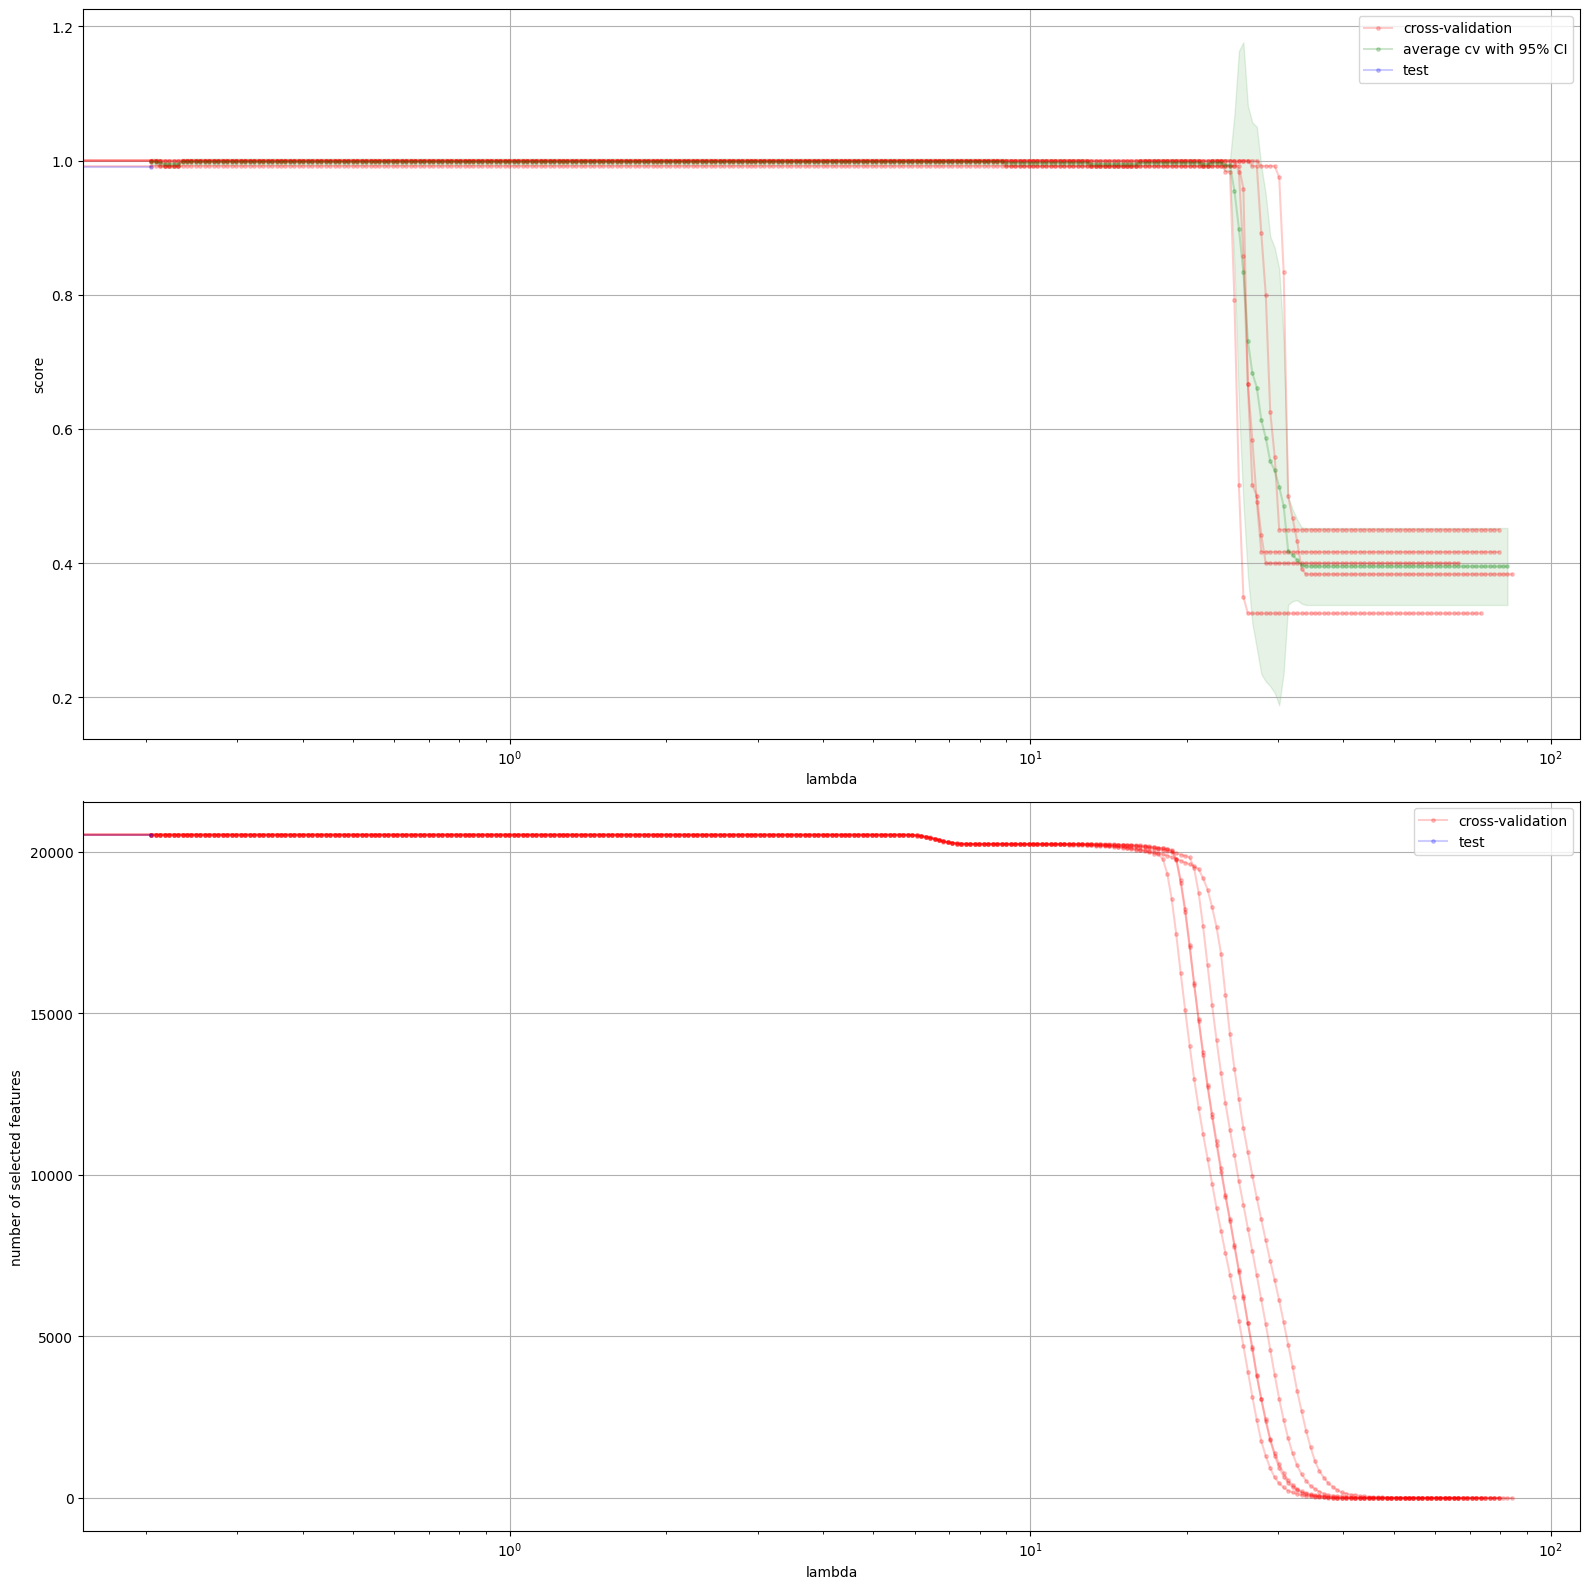

In [8]:
# define the model

# LassoNet + Cross-Validation
model1=LassoNetClassifierCV()
model1.path(X_train, y_train, return_state_dicts=True)
print("Best model scored", model1.score(X_test, y_test))
plot_cv(model1, X_test, y_test)
plt.savefig("gene_cancer_cv.png")

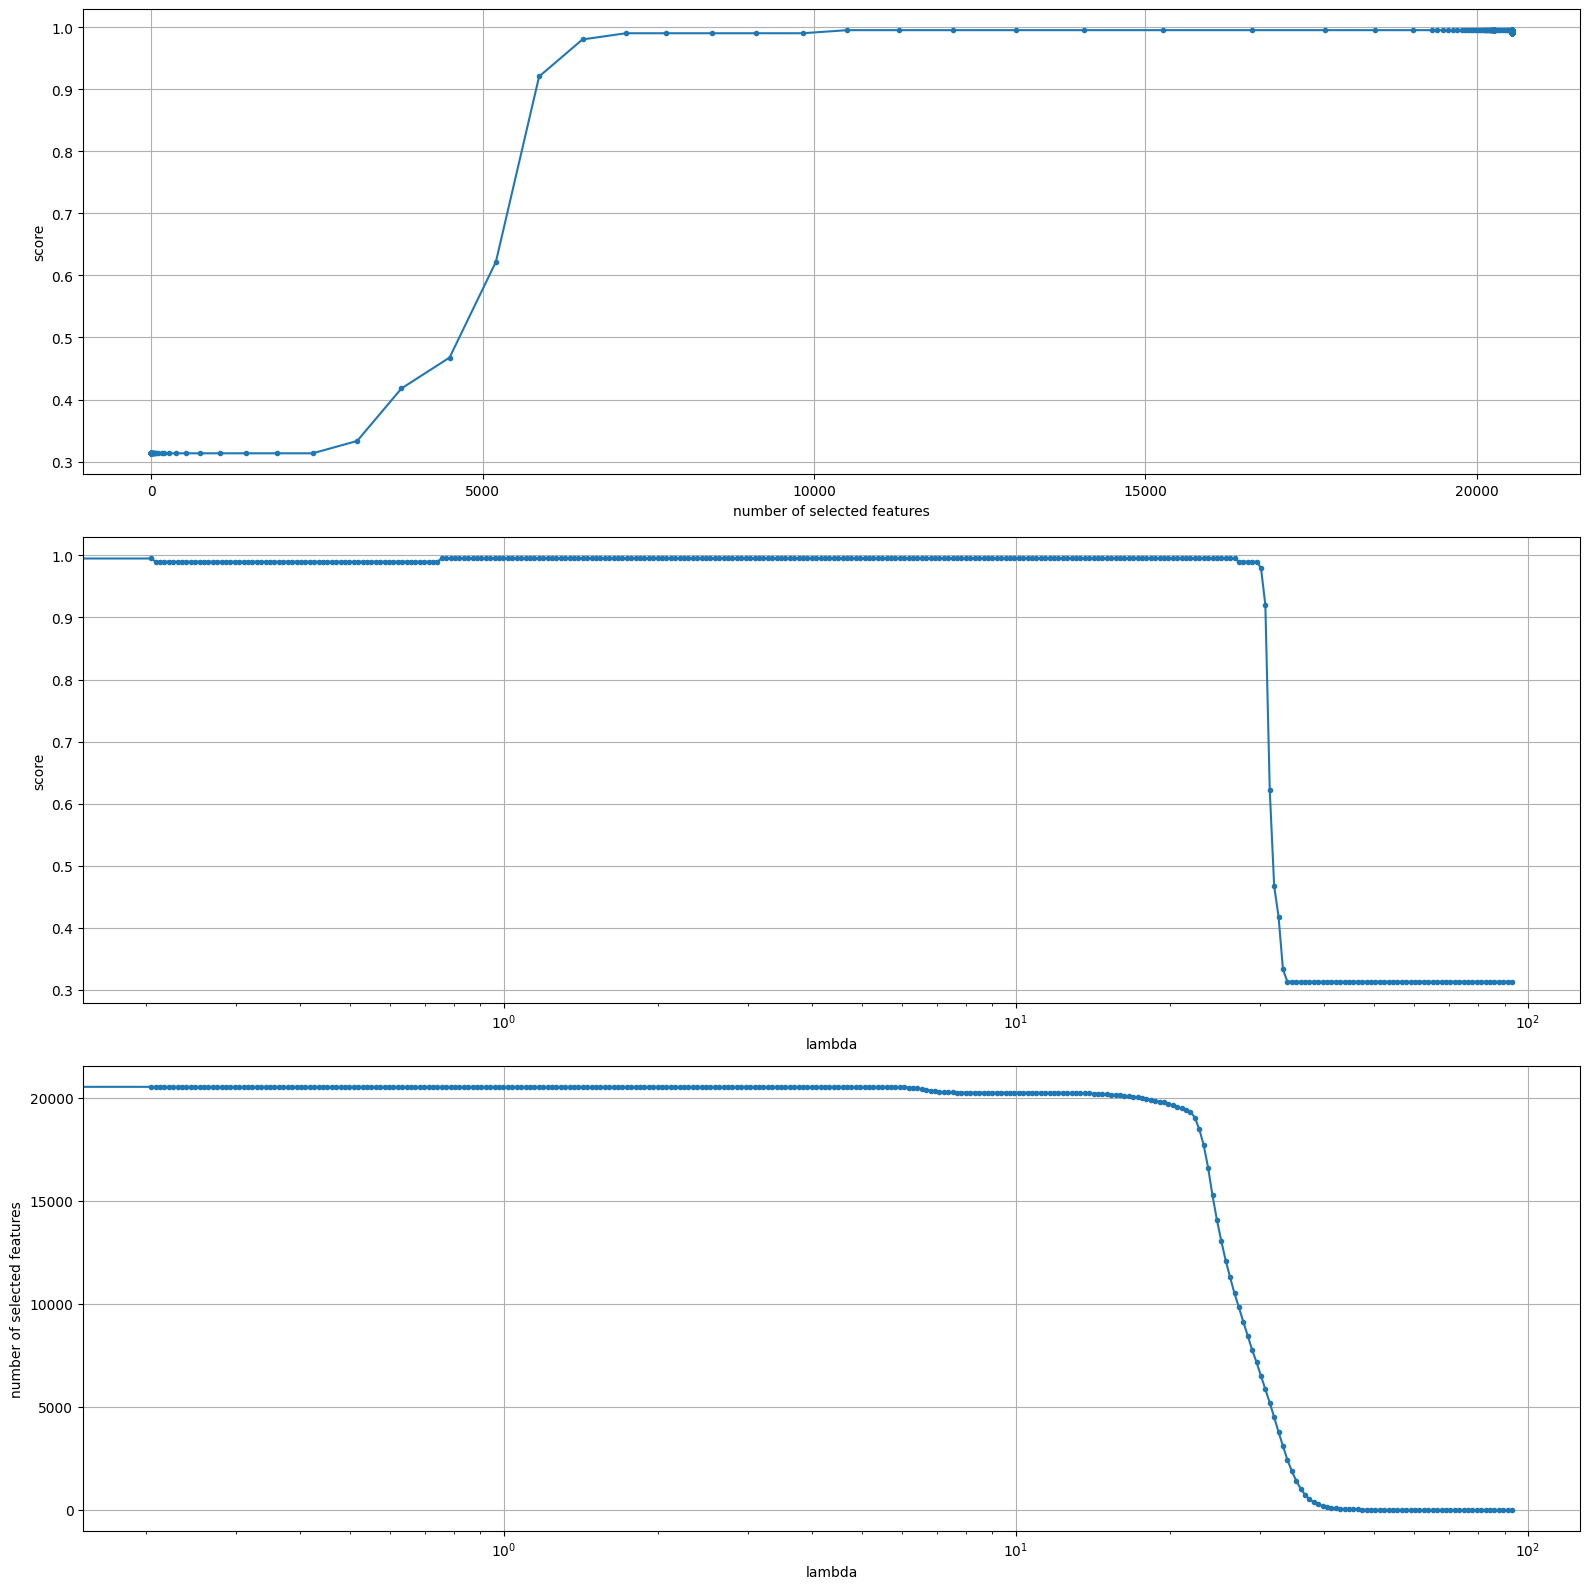

In [9]:
# LassoNet
model2=LassoNetClassifier()
path2=model2.path(X_train, y_train, return_state_dicts=True)
plot_path(model2, X_test, y_test)
plt.savefig("gene_cancer.png")

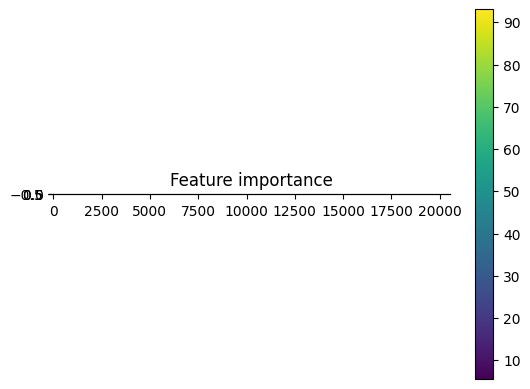

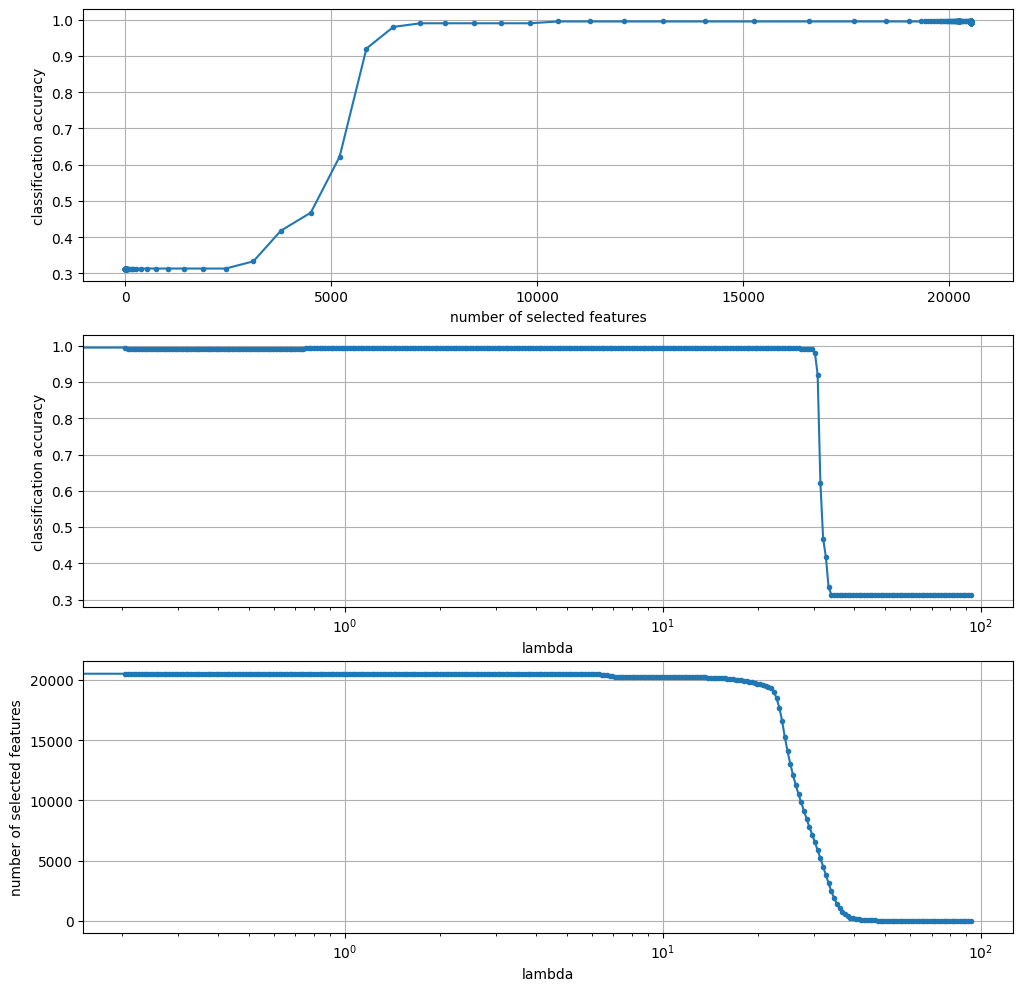

In [10]:
img = model2.feature_importances_.reshape(1, 20531)

plt.title("Feature importance")
plt.imshow(img)
plt.colorbar()
plt.savefig("gene-classification-importance.png")

n_selected = []
accuracy = []
lambda_ = []

for save in path2:
    model2.load(save.state_dict)
    y_pred = model2.predict(X_test)
    n_selected.append(save.selected.sum())
    accuracy.append(accuracy_score(y_test, y_pred))
    lambda_.append(save.lambda_)

to_plot = [160, 220, 300]

fig = plt.figure(figsize=(12, 12))

plt.subplot(311)
plt.grid(True)
plt.plot(n_selected, accuracy, ".-")
plt.xlabel("number of selected features")
plt.ylabel("classification accuracy")

plt.subplot(312)
plt.grid(True)
plt.plot(lambda_, accuracy, ".-")
plt.xlabel("lambda")
plt.xscale("log")
plt.ylabel("classification accuracy")

plt.subplot(313)
plt.grid(True)
plt.plot(lambda_, n_selected, ".-")
plt.xlabel("lambda")
plt.xscale("log")
plt.ylabel("number of selected features")

plt.savefig("gene-classification-training.png")

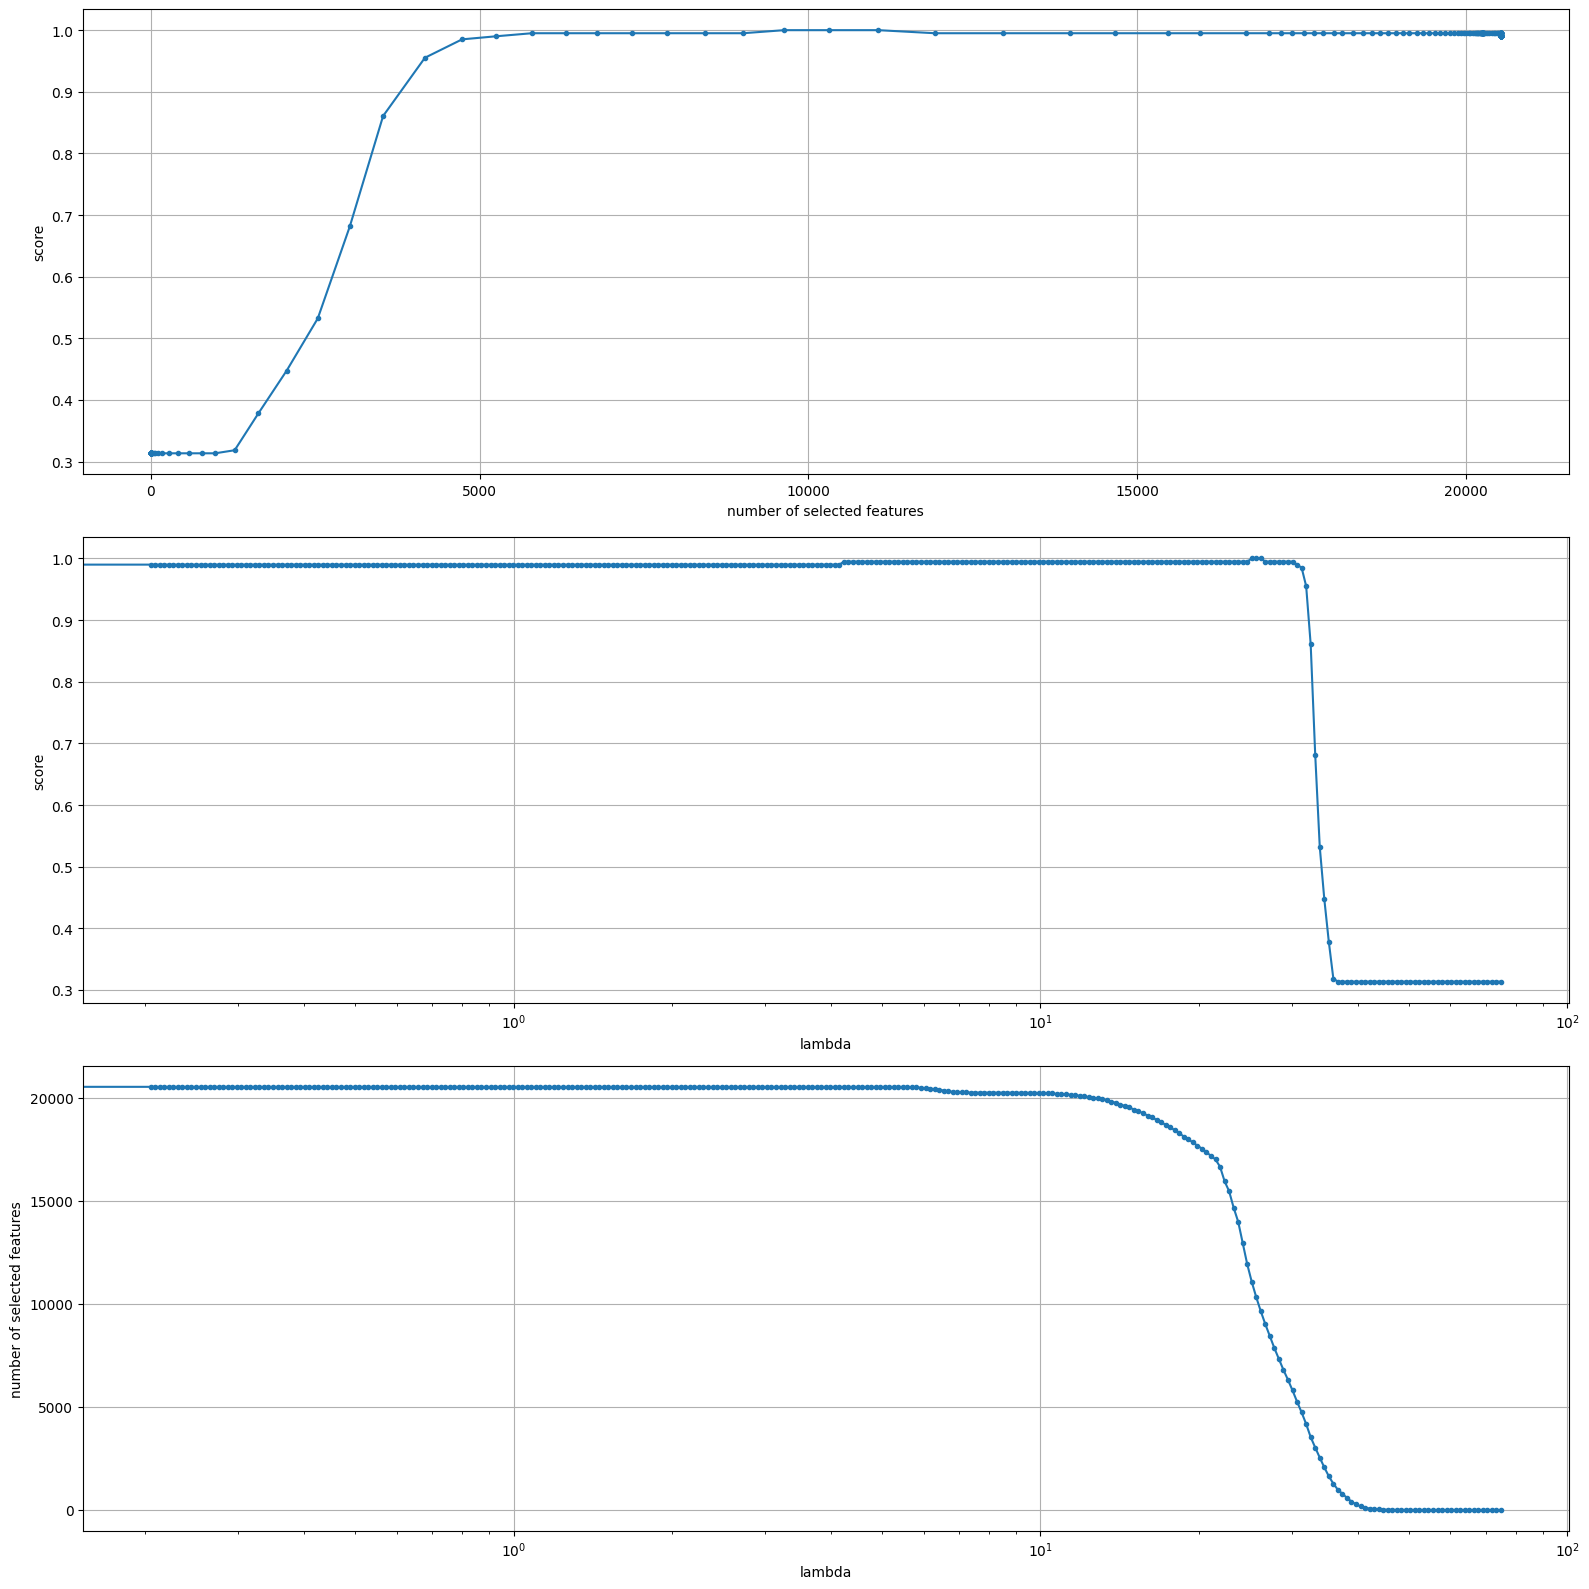

In [11]:
# LassoNet + dropout
model3=LassoNetClassifier(dropout=0.5)
path3=model3.path(X_train, y_train, return_state_dicts=True)
plot_path(model3, X_test, y_test)
plt.savefig("gene_cancer_dropout.png")

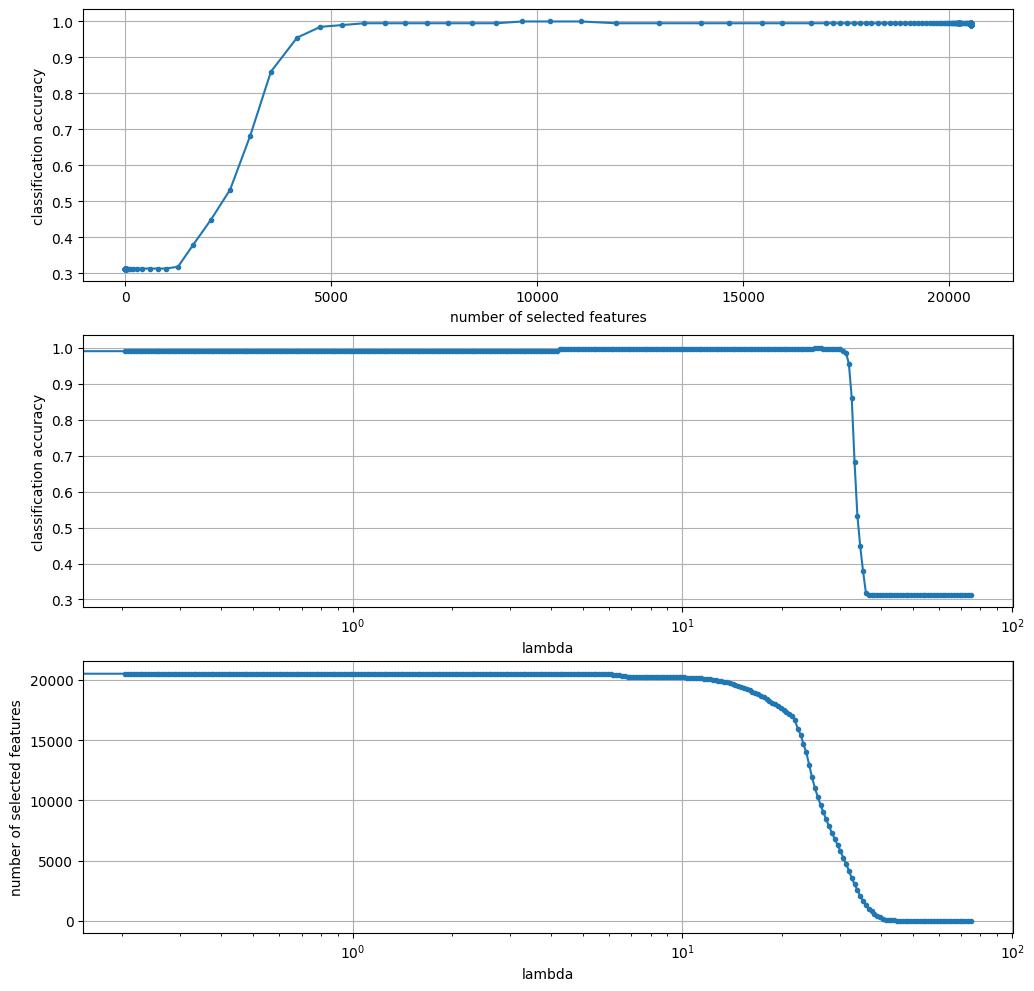

In [22]:
img = model3.feature_importances_.reshape(1, 20531)

n_selected = []
accuracy = []
lambda_ = []

for save in path3:
    model2.load(save.state_dict)
    y_pred = model2.predict(X_test)
    n_selected.append(save.selected.sum())
    accuracy.append(accuracy_score(y_test, y_pred))
    lambda_.append(save.lambda_)

to_plot = [160, 220, 300]

fig = plt.figure(figsize=(12, 12))

plt.subplot(311)
plt.grid(True)
plt.plot(n_selected, accuracy, ".-")
plt.xlabel("number of selected features")
plt.ylabel("classification accuracy")

plt.subplot(312)
plt.grid(True)
plt.plot(lambda_, accuracy, ".-")
plt.xlabel("lambda")
plt.xscale("log")
plt.ylabel("classification accuracy")

plt.subplot(313)
plt.grid(True)
plt.plot(lambda_, n_selected, ".-")
plt.xlabel("lambda")
plt.xscale("log")
plt.ylabel("number of selected features")

plt.savefig("gene-classification-training_model3.png")

In [13]:
# Lasso classifier (not LassoNet)

from sklearn.linear_model import Lasso

alpha=[0.0001, 0.001, 0.1, 1]

for i in alpha:
  # Lasso regression
  model4 = Lasso(alpha=i)
  model4.fit(X_train_1, Y_train)

  # make predictions
  y_pred = model4.predict(X_test_1)

  # evaluate the model
  acc = accuracy_score(Y_test, y_pred.round())

  print(f"Accuracy: {acc}")

Accuracy: 1.0
Accuracy: 0.6019900497512438
Accuracy: 0.0
Accuracy: 0.0


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - accuracy: 0.3095 - loss: 1.5289 - val_accuracy: 0.3930 - val_loss: 1.3962
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5132 - loss: 1.3470 - val_accuracy: 0.5522 - val_loss: 1.1686
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7040 - loss: 1.0554 - val_accuracy: 0.7861 - val_loss: 0.8215
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7896 - loss: 0.6780 - val_accuracy: 0.8557 - val_loss: 0.4937
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8764 - loss: 0.4411 - val_accuracy: 0.9900 - val_loss: 0.2533
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9886 - loss: 0.2009 - val_accuracy: 0.9851 - val_loss: 0.1431
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9983 - loss: 0.1172 - val_accuracy: 0.9900 - val_loss: 0.0885
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9948 - loss: 0.0622 - val_accuracy: 0.9950 - 

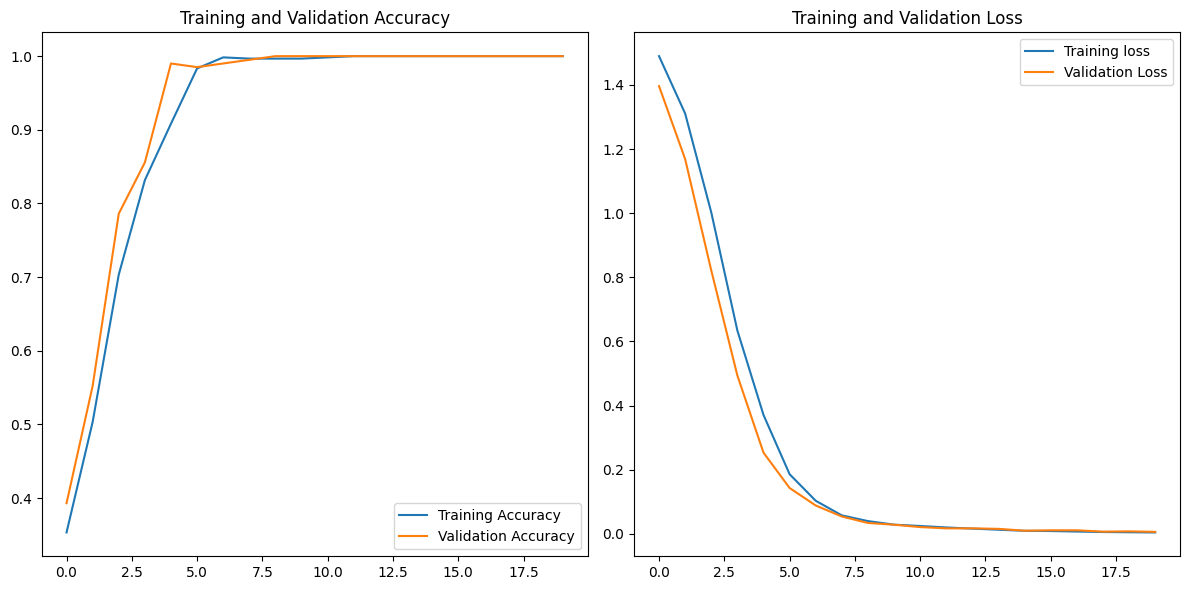

In [16]:
# model 5: deep feedforward neurla network

model5=Sequential()
model5.add(Dense(1024, input_shape=(20531,), activation='relu'))
model5.add(Dense(256, activation='relu'))
model5.add(Dense(5, activation='softmax'))

model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history=model5.fit(X_train_1, Y_train, epochs=20, batch_size=64, validation_data=(X_test_1, Y_test))

_, train_accuracy = model5.evaluate(X_train_1, Y_train, verbose=0)
_, test_accuracy = model5.evaluate(X_train_1, Y_train, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_accuracy, test_accuracy))

# plot
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.savefig('gene_model5.png')
plt.show()